# Проект "Voice Emotion Recognition"

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd
import os
import sys
import warnings
import wave

plt.style.use('ggplot')
warnings.simplefilter("ignore")

# Загрузка данных

In [134]:
CREMA = "D:\CyberFace Project\Data\CREMA-D\\"

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']

In [135]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [136]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
df = pd.DataFrame(emotion, columns = ['labels'])
df['source'] = 'CREMA'
df = pd.concat([df,pd.DataFrame(path, columns = ['path'])],axis=1)
df.labels.value_counts()

male_disgust      671
male_sad          671
male_happy        671
male_fear         671
male_angry        671
female_fear       600
female_disgust    600
female_angry      600
female_sad        600
female_happy      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

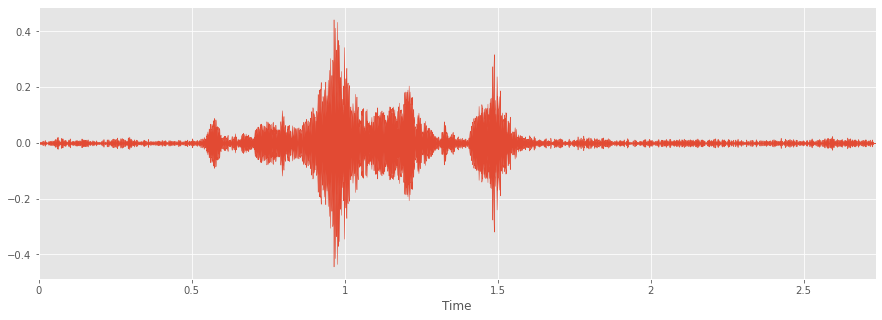

In [137]:
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

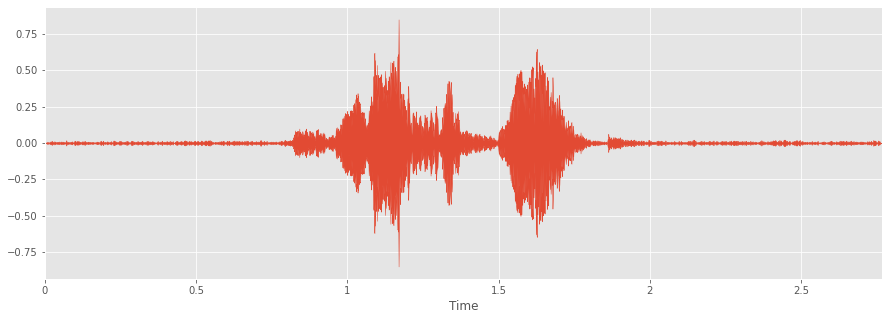

In [138]:
fname = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

In [131]:
df.head()

,labels,path
0,angry,D:\CyberFace Project\Data\SAVEE\DC_a01.wav
1,angry,D:\CyberFace Project\Data\SAVEE\DC_a02.wav
2,angry,D:\CyberFace Project\Data\SAVEE\DC_a03.wav
3,angry,D:\CyberFace Project\Data\SAVEE\DC_a04.wav
4,angry,D:\CyberFace Project\Data\SAVEE\DC_a05.wav


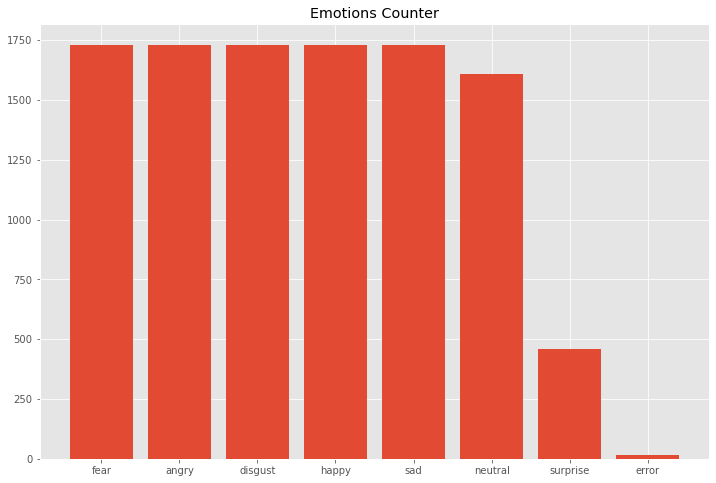

In [66]:
fig, ax = plt.subplots()
ax.bar(['fear', 'angry', 'disgust', 'happy', 'sad', 'neutral', 'surprise', 'error'], df.labels.value_counts())
ax.set_title('Emotions Counter')

fig.set_figheight(8)
fig.set_figwidth(12)

### Визуализация

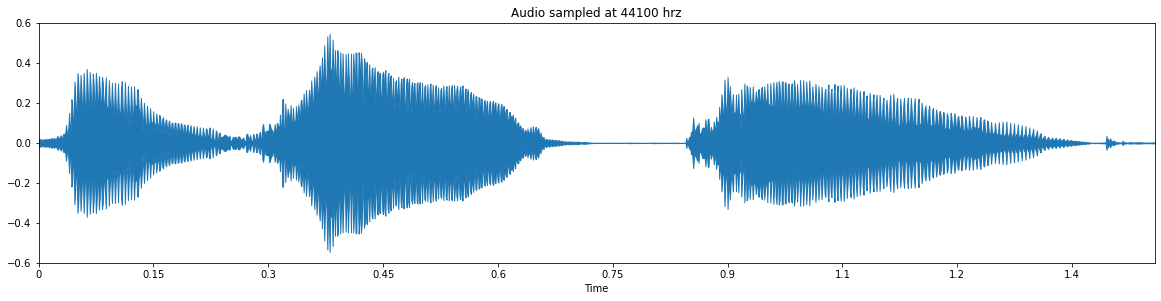

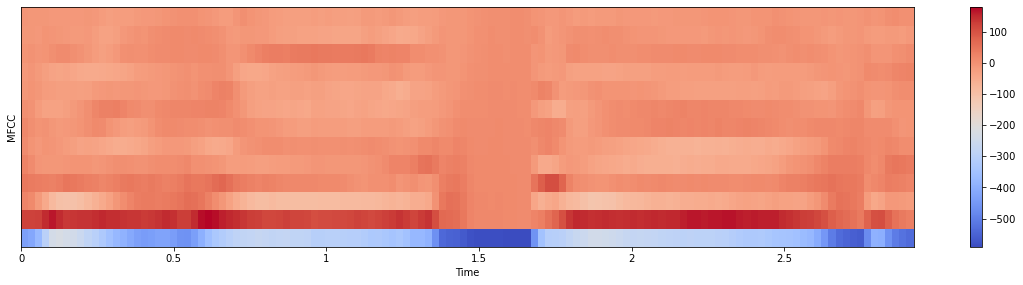

In [31]:
path = CREMA + '1001_DFA_ANG_XX.wav'
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

# Обработка признаков

In [139]:
def load_wav(path, sr=8000):
    return librosa.load(path, sr=sr)

In [140]:
def extract_voice_features(voice_folder, numcep=13, hop_length=256):
    voice_vectors = []
    indices = []
    for record_name in os.listdir(voice_folder):
        """ alternate way
        X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 ) # load_wav
                                    
        sample_rate = np.array(sample_rate)

        # mean as the feature. Could do min and max etc as well. 
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
        """
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        signal, sr = load_wav(
            os.path.join(voice_folder, record_name)
        )
        mfcc_features = librosa.feature.mfcc(
            signal, sr=sr, n_mfcc=numcep, hop_length=hop_length
        )
        voice_vector = mfcc_features.mean(axis=1)
        voice_vectors.append(voice_vector)
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
    })

In [142]:
%%time
vf = extract_voice_features(CREMA)

Wall time: 4min 32s


In [144]:
X = np.vstack(vf.voice_vector)
y = df.labels
X.shape, y.shape

((7442, 13), (7442,))

# Baseline

In [145]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Обработка данных

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

Нормируем признаки

#### 1ый способ

In [152]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

#### 2й способ

In [ ]:
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

...

In [153]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(lb.classes_)

(5581, 13)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'male_angry' 'male_disgust' 'male_fear'
 'male_happy' 'male_neutral' 'male_sad']


In [154]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(5581, 13, 1)

### Моделирование

In [168]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(12)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 13, 256)           2304      
_________________________________________________________________
activation_24 (Activation)   (None, 13, 256)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 13, 256)           524544    
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 256)           1024      
_________________________________________________________________
activation_25 (Activation)   (None, 13, 256)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 256)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 13, 128)          

In [169]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
349/349 [==============================] - 14s 35ms/step - loss: 2.4773 - accuracy: 0.1015 - val_loss: 2.4795 - val_accuracy: 0.0978
Epoch 2/100
349/349 [==============================] - 12s 34ms/step - loss: 2.4390 - accuracy: 0.1573 - val_loss: 2.4217 - val_accuracy: 0.1886
Epoch 3/100
349/349 [==============================] - 12s 34ms/step - loss: 2.3925 - accuracy: 0.1870 - val_loss: 2.3740 - val_accuracy: 0.2080
Epoch 4/100
349/349 [==============================] - 12s 35ms/step - loss: 2.3425 - accuracy: 0.2020 - val_loss: 2.3324 - val_accuracy: 0.2155
Epoch 5/100
349/349 [==============================] - 12s 35ms/step - loss: 2.2830 - accuracy: 0.2393 - val_loss: 2.2886 - val_accuracy: 0.2327
Epoch 6/100
349/349 [==============================] - 12s 35ms/step - loss: 2.2508 - accuracy: 0.2391 - val_loss: 2.2457 - val_accuracy: 0.2735
Epoch 7/100
349/349 [==============================] - 12s 35ms/step - loss: 2.1994 - accuracy: 0.2656 - val_loss: 2.2014 - val_ac

In [170]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5581, 13, 1), (1861, 13, 1), (5581, 12), (1861, 12))

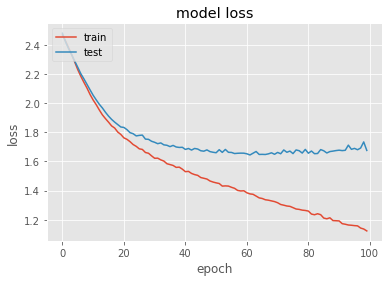

In [171]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Первое тестирование

In [175]:
TEST = 'D:\CyberFace Project\Data\TEST\\'

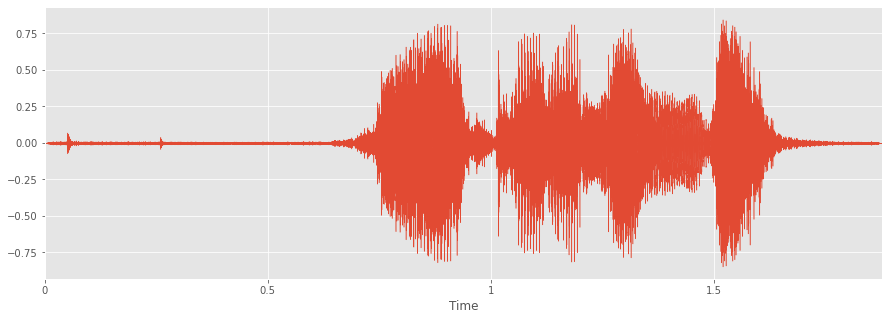

In [194]:
fname = TEST + 'test_male_angry.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

In [201]:
test = extract_voice_features(TEST + 'test_male_sad\\')
test = np.vstack(test.voice_vector)
test = (test - mean) / std
test = np.expand_dims(test, axis=2)

In [202]:
p = model.predict(test)

In [203]:
p

array([[2.0306983e-05, 1.4497530e-02, 6.2645520e-03, 4.1275877e-03,
        3.7511349e-02, 1.1335802e-02, 5.5227196e-03, 3.0018039e-02,
        3.2738121e-03, 1.5937802e-01, 7.2495538e-01, 3.0949130e-03]],
      dtype=float32)

In [200]:
lb.classes_

array(['female_angry', 'female_disgust', 'female_fear', 'female_happy',
       'female_neutral', 'female_sad', 'male_angry', 'male_disgust',
       'male_fear', 'male_happy', 'male_neutral', 'male_sad'],
      dtype=object)

In [205]:
model_name = 'voice_emotion_model_1.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\bicda\YandexDisk\CyberFace\Data\saved_models\voice_emotion_model_1.h5 


### Анализ модели

In [206]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 39.39%


In [211]:
preds = model.predict(X_test, batch_size=16, verbose=1)
preds=preds.argmax(axis=1)
preds

117/117 [==============================] - 0s 4ms/step


array([ 6,  1,  4, ..., 10,  3,  3], dtype=int64)

In [212]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))

actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))

Выведем матрицу ошибок:

In [213]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.3938742611499194


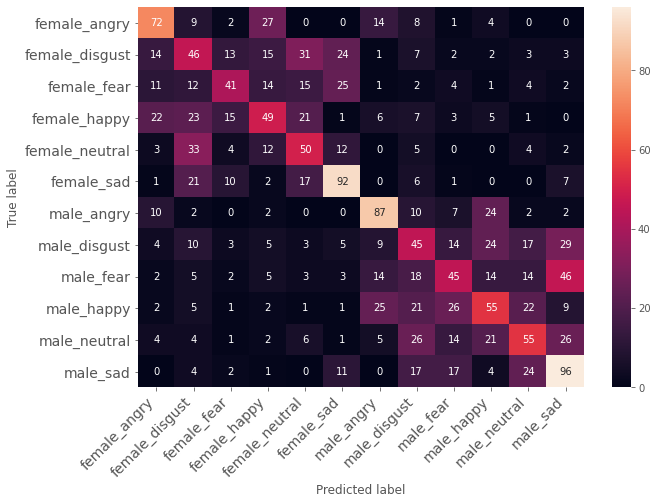

In [216]:
import seaborn as sns

classes = np.unique(actual)
classes.sort()

c = confusion_matrix(actual, preds)
print(accuracy_score(actual, preds))
print_confusion_matrix(c, class_names = classes)

In [217]:
classes = np.unique(actual)
classes.sort()    
print(classification_report(actual, preds, target_names=classes))

                precision    recall  f1-score   support

  female_angry       0.50      0.53      0.51       137
female_disgust       0.26      0.29      0.27       161
   female_fear       0.44      0.31      0.36       132
  female_happy       0.36      0.32      0.34       153
female_neutral       0.34      0.40      0.37       125
    female_sad       0.53      0.59      0.55       157
    male_angry       0.54      0.60      0.56       146
  male_disgust       0.26      0.27      0.26       168
     male_fear       0.34      0.26      0.30       171
    male_happy       0.36      0.32      0.34       170
  male_neutral       0.38      0.33      0.35       165
      male_sad       0.43      0.55      0.48       176

      accuracy                           0.39      1861
     macro avg       0.39      0.40      0.39      1861
  weighted avg       0.39      0.39      0.39      1861



### Анализ точности предсказания пола

0.8828586781300376


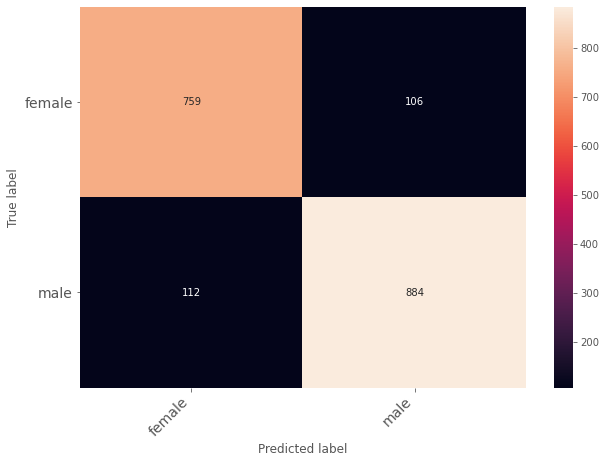

In [225]:
gender_actual = pd.Series(actual).replace({'female_angry':'female'
                                           , 'female_disgust':'female'
                                           , 'female_fear':'female'
                                           , 'female_happy':'female'
                                           , 'female_sad':'female'
                                           , 'female_surprise':'female'
                                           , 'female_neutral':'female'
                                           , 'male_angry':'male'
                                           , 'male_fear':'male'
                                           , 'male_happy':'male'
                                           , 'male_sad':'male'
                                           , 'male_surprise':'male'
                                           , 'male_neutral':'male'
                                           , 'male_disgust':'male'
                                          })

gender_preds = pd.Series(preds).replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = np.unique(gender_actual)
classes.sort() 

c = confusion_matrix(gender_actual, gender_preds)
print(accuracy_score(gender_actual, gender_preds))
print_confusion_matrix(c, class_names = classes)

### Анализ непосредственно эмоций

In [ ]:
emote_actual = pd.Series(actual).replace({'female_angry':'angry'
                                           , 'female_disgust':'disgust'
                                           , 'female_fear':'fear'
                                           , 'female_happy':'happy'
                                           , 'female_sad':'sad'
                                           , 'female_surprise':'surprise'
                                           , 'female_neutral':'neutral'
                                           , 'male_angry':'angry'
                                           , 'male_fear':'fear'
                                           , 'male_happy':'happy'
                                           , 'male_sad':'sad'
                                           , 'male_surprise':'surprise'
                                           , 'male_neutral':'neutral'
                                           , 'male_disgust':'disgust'
                                          })

emote_preds = pd.Series(preds).replace({'female_angry':'angry'
                                           , 'female_disgust':'disgust'
                                           , 'female_fear':'fear'
                                           , 'female_happy':'happy'
                                           , 'female_sad':'sad'
                                           , 'female_surprise':'surprise'
                                           , 'female_neutral':'neutral'
                                           , 'male_angry':'angry'
                                           , 'male_fear':'fear'
                                           , 'male_happy':'happy'
                                           , 'male_sad':'sad'
                                           , 'male_surprise':'surprise'
                                           , 'male_neutral':'neutral'
                                           , 'male_disgust':'disgust'
                                          })

classes = np.unique(emote_actual)
classes.sort() 

c = confusion_matrix(emote_actual, emote_preds)
print(accuracy_score(emote_actual, emote_preds))
print_confusion_matrix(c, class_names = classes)

## Возможность протестировать в режиме on-line

In [3]:
CHUNK = 1024 
FORMAT = pyaudio.paInt16 
CHANNELS = 2 
RATE = 44100 
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "test audio\\testing.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

NameError: name 'pyaudio' is not defined

In [4]:
import pyaudio
# pip install pipwin 
# pipwin install pyaudio

ModuleNotFoundError: No module named 'pyaudio'

## Part 5